# Chapter 8: Operator Formulation Of The Continuity Equation

We start now our travel into the world of linear operators. This is probably the most abstract concept in this course. It will require some effort from the reader who is not familiar with matrices and vectors. As for the rest of this book, we learn this subject by a series of examples, which shuold give you a general understanding of how to create a linear operator in the form of a 2D array in Numerical Python. The final goal of this Experience is to build an exact, compact and fast operator that calculates the Strain Rate tensor. This can be straightaway applied to solving the continuity equation for an incompressible flow, which is the trace of the Strain Rate tensor. 

### Continuity Equation

Continuity equation can be simply understood by its physical meaning, which is that the material change inside a given volume is equal to the flux of material in and out of the volume. We define flux with the vector ${\bf j}=\rho {\bf v}$, where $\rho$ is the density and ${\bf v}$ is the velocity vector. If the volume is small enough the difference between the flux that enters and leaves the volume is simply given by the derivative. For example in the $x$ direction it can be expressed as: 

\begin{equation}
\Delta j_x(x_0,y_0) = j_x\left(x_0+\frac{\Delta x}{2},y_0\right) - j_x\left(x_0-\frac{\Delta x}{2},y_0\right) \approx \frac{\partial j_x}{\partial x} \left(x_0,y_0\right) \Delta x
\end{equation}

by extending it in the other directions, one can write the entire continuity equation in function of the density $\rho$ and of the flux ${\bf j}$:

\begin{equation}
\frac{\partial \rho }{\partial t} +\frac{ \partial j_x}{\partial x} + \frac{\partial j_y}{\partial y} = \frac{\partial \rho }{\partial t} + \nabla  \cdot \mathbf{j} = 0
\end{equation}

This can be rewritten in function of the density $\rho$ and of the velocity ${\bf v}$ by exploiting the definition of flux and calculating the derivative in detail:
\begin{equation}
\nabla  \cdot \mathbf{j} = \nabla  \cdot \left(\rho \mathbf{v} \right) = \left( \nabla \rho \right) \cdot \mathbf{v} + \rho \nabla \cdot \mathbf{v}
\end{equation}

where with $\nabla \rho$ we expressed the gradient vector of the density $\left(\frac{\partial \rho}{\partial x} ,  \frac{\partial \rho}{\partial y}\right)$. 

Finally this allows rewriting the continuity equation as:
\begin{equation}
\frac{d \rho}{ dt} + \rho \nabla \cdot \mathbf{v} = 0
\end{equation}

where we used the definition of the full derivative $ \frac{d \rho}{ dt} = \frac{\partial \rho }{\partial t} +  \left( \nabla \rho \right) \cdot \mathbf{v}$. The most important consequence of this expression is that for the special case of incompressible flow $\frac{d \rho}{ dt} = 0$, and therefore continuity equation simply reduces to 

\begin{equation}
\nabla \cdot \mathbf{v} = 0
\end{equation}

We will verify this simplified version of the continuity equation for flows introduced earlier, and more in general calculate the full strain rate tensor. Since strain rates involve both derivatives in the $x$ and $y$ direction of fluxes in in $x$ and $y$, this will give us the opportunity to understand how to calculate in the simplest way the best approximation for derivative operators in 2D. The 3D extension follows in a straightforward manner. In particular it will be important to show how determined choices only allow building derivative operators that are correct down to machine precision even with modest model resolutions.

## Strain Rates

Given an internally deforming body in a square box, how do we quantify the rate and the amount of deformation? Since every point of the body is moving at a different velocity (speed and direction) the deformation is physically quantified by how different is the displacement (${\bf s}$) or velocity (${\bf v}$) from one point to another. By looking at the limit to infinitely close points, we obtain two quantities called Strain ${\bf \epsilon}$ or Strain Rate ${\bf \dot{\epsilon}}$ :

\begin{align}
{\bf \epsilon}_{ij} &= \frac{1}{2} \left( \frac{\partial s_i}{\partial x_j} + \frac{\partial s_j}{\partial x_i} \right) \nonumber \\ 
{\bf \dot{\epsilon}}_{ij} &= \frac{1}{2} \left( \frac{\partial v_i}{\partial x_j} + \frac{\partial v_j}{\partial x_i} \right) \label{eq:strainRates}
\end{align} 
 
To understand strain, strain rate and energies, the best is to use an example. We can for example take the 2D flow in the above equation, and calculate its x and y derivatives, which will give us the strain rate. There are fundamentally two strategies to approximate derivatives using Numerical Python. One is to do it directly, by differentiating the array with the definition of derivatives, the other is to create an Operator in form of a matrix that calculates the derivative for us. Let's look at both approaches, since they are both useful for achieving different targets.

### Thinning Flow

A useful flow making calculation is this one, that is often used in the literature to test advection. It is contained in a square but it rotates around its center, with different velocities. It is defined by: $v_x = - \sin^2(\pi x) \sin(\pi y) \cos(\pi y)$ and $v_y = \sin^2(\pi y) \sin(\pi x) \cos(\pi x)$.

### Exercise 1

Visualize the Thinning flow with streamlines and arrows, as we did in the advection Experience.

In [ ]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

nxp=201; nxc=nxp-1; nyp=201; nyc=nyp-1
xTot=1.0; dx=xTot/nxc; xMin=-xTot/2.0; xMax=xTot/2.0
yTot=1.0; dy=yTot/nyc; yMin=-yTot/2.0; yMax=yTot/2.0

# allocate the lattice arrays
X = np.arange(nxp, dtype=float)*dx+xMin  # x lattice coordinates
Y = np.arange(nyp, dtype=float)*dy+yMin  # y lattice coordinates

Vx = np.zeros((nxp,nyp), float)  # x-velocity at nodes
Vy = np.zeros((nxp,nyp), float)  # y-velocity at nodes

xNorm=(X+xMin)/xTot
yNorm=(Y+yMin)/yTot
for iy in np.arange(0,nyp):
    Vx[:,iy] = np.sin(np.pi*xNorm) * np.sin(np.pi*xNorm) * np.sin(np.pi*yNorm[iy]) * np.cos(np.pi*yNorm[iy])
for ix in np.arange(0,nxp):
    Vy[ix,:] =- np.sin(np.pi*yNorm) * np.sin(np.pi*yNorm) * np.sin(np.pi*xNorm[ix]) * np.cos(np.pi*xNorm[ix])

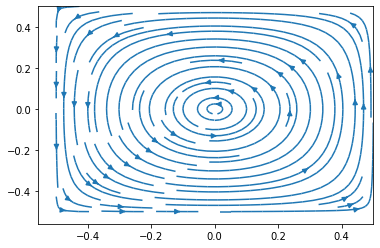

In [ ]:
#Plot the velocities Vx and Vy onto the X and Y cordinate system, you do not have to transpose if you input the function as (Y,X)
plt.streamplot(X,Y,Vx.transpose(),Vy.transpose())


The four analytical derivatives of the thinning flow allow us to calculate the strain rate:

\begin{align}
\frac{\partial {\bf v}}{\partial {\bf x}} = \left(
		\begin{array}{ccc}
			 \frac{\partial v_x}{\partial x} & \frac{\partial v_x}{\partial y} \\			 
			 \frac{\partial v_y}{\partial x} & \frac{\partial v_y}{\partial y} 
		\end{array} \right) = \left(
		\begin{array}{ccc}
		    -2  \pi \sin(\pi x) \cos(\pi x) \sin(\pi y) \cos(\pi y)  & -\pi \sin^2(\pi x) \lbrack \cos^2(\pi y) - \sin^2(\pi y) \rbrack \\\
			\pi \sin^2(\pi y) \lbrack  \cos^2(\pi x) - \sin^2(\pi x) \rbrack & -2 \pi \sin(\pi y) \cos(\pi y) \sin(\pi x) \cos(\pi x) 	
		\end{array} \right)
\end{align}

A quick look at the analytically calculated strain rates tells us that this flow is conservative, i.e. $\frac{\partial v_x}{\partial x} + \frac{\partial v_y}{\partial y} = 0$. Let's now check whether this property is found by our calculation of the derivatives. 

The most important fact about calculating a derivative on a discretized lattice is that we have to think about where it is calculated. If we take the values at the nodes of a lattice, the derivatives will be calculated at the mid point between two nodes. This implies that the x-derivative and the y-derivative will be located in two different points. Let's see what are the implications of such an approximation by testing the validity of the continuity equation in the most straightforward way:

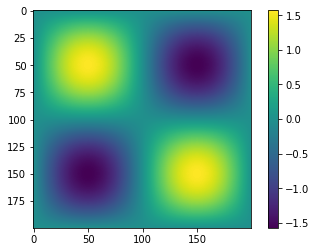

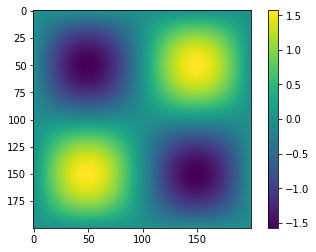

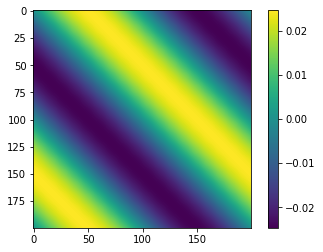

In [ ]:
Dvx = (Vx[1:nxp,0:nyp-1]-Vx[0:nxp-1,0:nyp-1])/dx
Dvy = (Vy[0:nxp-1,1:nyp]-Vy[0:nxp-1,0:nyp-1])/dy

p = plt.imshow(Dvx)
plt.colorbar()
plt.show()

p = plt.imshow(Dvy)
plt.colorbar()
plt.show()

p = plt.imshow(Dvx+Dvy)
plt.colorbar()
plt.show()

Where Vx, Vy are the same defined in the past chapter. Dvx and Dvy do not need to be allocated. By defining them in this way, the arrays are automatically allocated by the Python parser, as we defined them as $(nxp-1) * (nyp-1) = nxc * nyc$ float arrays. This method is very compact and fast, however the result, shown on the above figure is not satisfactory. The intensity of the flow is about 1, and the precision of the calculation of the continuity equation oscillates between $-0.05$ and $+0.05$ as. 

### Exercise 2

Clearly this performance can be improved by increasing the mesh resolution. One can in fact calculate it with a $1000 \times 1000$ mesh and indeed it improves of one order of magnitude. But why is this happening? Can we improve this calculation without increasing the resolution? Indeed there is a better way to improve this result, which is to calculate the two derivatives at the same point, the center of the cell. Let's do it numerically!

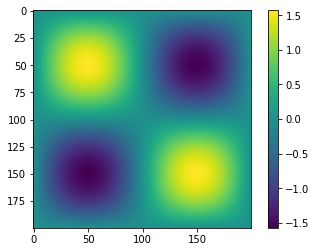

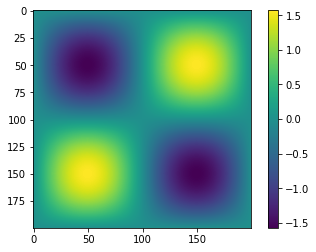

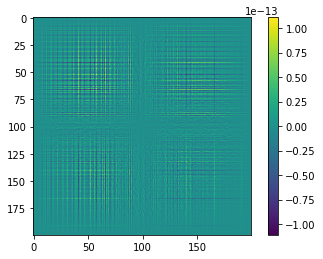

(200, 200)

In [ ]:
# Dvx = (Vx[1:nxp,0:nyp-1]-Vx[0:nxp-1,0:nyp-1])/dx

# we want the center of the pixel, so the y range for Dvx has to change as well.
Dvx = ( ((Vx[1:nxp,1:nyp] + Vx[1:nxp,0:nyp-1])/2) - ((Vx[0:nxp-1,1:nyp] + Vx[0:nxp-1,0:nyp-1])/2) )/dx

Dvy = ( ((Vy[0:nxp-1,1:nyp] + Vy[1:nxp,1:nyp])/2) - ((Vy[1:nxp,0:nyp-1] + Vy[0:nxp-1,0:nyp-1])/2) )/dy







p = plt.imshow(Dvx)
plt.colorbar()
plt.show()
p = plt.imshow(Dvy)
plt.colorbar()
plt.show()
p = plt.imshow(Dvx+Dvy)
plt.colorbar()
plt.show()

np.shape(Dvx)


We see that the difference is striking, that the cell-centered approximated equation is many orders of magnitude better than the approximation that we made earlier. In fact it simply reaches machine precision for this analytically defined flow. 

This very important lesson instructs us on the importance of using rigorously cell-centered finite difference. This technique, analogue to staggered-grid finite difference (where the staggered grid is a half side shifted grid, with the nodes at the center of the standard grid), to finite volume and and others, is based on the technical, but essential, property that the physical equations are solved at the center of the cell. The implication is that we need to develop algorithms such that all the quantities are finally calculated at the same point, most commonly the center of the cell.

### Exercise 3

Let's finally test our cell-centered approximation, calculate the entire strain rate at the cell center and compare it with the analytical one. We have already seen how to calculate ${\bf \dot{\epsilon}}_{xx}$ and ${\bf \dot{\epsilon}}_{yy}$, by averaging nodal velocity on one axis, and then differentiating respect to the other axis, in order to end up in the cell center. In order to calculate ${\bf \dot{\epsilon}}_{xy}$, that is equal by definition to  ${\bf \dot{\epsilon}}_{yx}$, we need to average on the alternative axis to the one in which we have to derive. Following this approach the calculation of ${\bf \dot{\epsilon}}_{xy}$ verify that it is very close to the analtical solution:

In [ ]:
# here write your solution

# It is unclear what this alternative axis is being referred to

Dvx = ( ((Vx[1:nxp,1:nyp] + Vx[1:nxp,0:nyp-1])/2) - ((Vx[0:nxp-1,1:nyp] + Vx[0:nxp-1,0:nyp-1])/2) )/dx

Dvy = ( ((Vy[0:nxp-1,1:nyp] + Vy[1:nxp,1:nyp])/2) - ((Vy[1:nxp,0:nyp-1] + Vy[0:nxp-1,0:nyp-1])/2) )/dy

DvXY = Dvx + Dvy

# Values are all very close to zero
print(DvXY)



[[ 0.00000000e+00  6.50521303e-19 -5.37764278e-17 ...  1.14925430e-17
   7.37257477e-18  2.54787511e-18]
 [-6.50521303e-19  0.00000000e+00 -1.66533454e-16 ...  3.90312782e-17
   2.42861287e-17  8.45677695e-18]
 [ 5.37764278e-17  1.66533454e-16  0.00000000e+00 ... -2.09901541e-16
  -1.25767452e-16 -4.11996826e-17]
 ...
 [-1.14925430e-17 -3.90312782e-17  2.09901541e-16 ...  0.00000000e+00
  -2.60208521e-18 -6.50521303e-19]
 [-7.37257477e-18 -2.42861287e-17  1.25767452e-16 ...  2.60208521e-18
   0.00000000e+00 -4.33680869e-19]
 [-2.54787511e-18 -8.45677695e-18  4.11996826e-17 ...  6.50521303e-19
   4.33680869e-19  0.00000000e+00]]


## Cell Centered Strain Rates from Linear Operators

Until now we have calculated derivatives explicitly. In the future however we plan to solve more complex problems where, in general, the flow law is not known. For example in the next chapters we will calculate the evolution of a system knowing only its physically conditions (density, viscosity, forces, etc.), and calculating the flow field from the momentum and continuity equations only. In order to develop algorithms able to solve these types of systems we will take advantage of using Operators. 

Operators are functional objects that act on function and perform operations on them. For example a derivative is an operation, and we will create operators derivatives to do that in different context. The advantage of creating these operators is that it can be shown that for any type of discretization of the space, they can be described by a matrix. And also the they form a so-called Group, which in simple terms means that we can apply an operator to another operator and obtain an operator. For example we can apply the derivative operator to another derivative operators and obtain a second derivative operator. In the same way we can create a Divergence Operator, and so on. These operations are all permitted because these operators, in 1D, 2D or 3D, are always 2d arrays (matrices) that operate on (1d) arrays, since we can always reshape the discretized field that we are interested in a 1D array, as seen in the past section.

Furthermore operations like the calculation of the momentum can be inverted if performed with linear operators and if these operators have the right properties. Let's see how can we write a linear operator that does the same calculations done in the previous lecture.

First of all we have to transform our 2D field array in a 1D array. This is done automatically by NumPy using the function reshape. Since we have ordered our field as $x,y$, reshape will automatically reorder any array first along the y axis and then the x axis. Using this property we can create a function that creates an operator which takes a $nxp \times nyp$ array and returns a $nxp \times (nyp-1)$ array where the values have been averaged on the side X of each cell, i.e. along the Y axis:


In [ ]:
# averaged because the mid point in cell is best, and -1 array because of derivative lose a datapoint

def buildSideOperatorX(nxp,nyp):
    nyc=nyp-1
    block=np.zeros((nyc,nyp),float); 
    block[0:nyc,0:nyc]+=0.5*np.diag(np.ones(nyc),0)
    block[0:nyc,1:nyp]+=0.5*np.diag(np.ones(nyc),0)
    return (np.kron(np.identity(nxp),block))



where only vectorized operations were used. Here the strategy is to create a block for each line that is $nyp$ long, and then use the function kron to place this block $nxp$ times along the diagonal. It is very important to realize that since the block is not squared, but $(nyp-1) \times nyp$, the final operator will not be squared. This is normal since the goal is to reduce the number of points where the field is calculated. To show how this operator looks like, I show here the case for nxp=3 and nyp=4, where one can see the jump from one block to the next every three rows, and the different number of total lines and rows:

[[0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]]


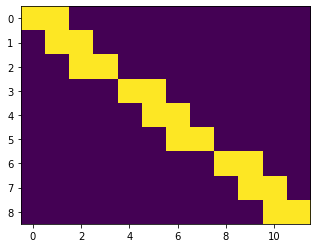

In [ ]:
import matplotlib.pyplot as plt
print(buildSideOperatorX(3,4))
plt.imshow(buildSideOperatorX(3,4))

Similarly an operator can be built for the side Y, in the X axis direction:

In [ ]:
def buildSideOperatorY(nxp,nyp):
    nxc=nxp-1
    outcome=np.zeros((nxc*nyp,nxp*nyp),float)
    outcome[0:nxc*nyp,0:nxc*nyp] += 0.5 * np.kron( np.identity(nxc) , np.identity(nyp) )
    outcome[0:nxc*nyp,nyp:nxp*nyp] += 0.5 * np.kron( np.identity(nxc) , np.identity(nyp) )
    return (outcome)

In [ ]:
A=buildSideOperatorY(3,5)
print(A)

[[0.5 0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.5]]


Here the strategy is similar, but the blocks are made of shifted identity matrixes. These operators can now be used to calculate the x and y side average, and therefore the cell average of all quantities. Let's use them with the flow above, but reducing the resolution. We will see soon later why we cannot use this approach with a square of 100 x 100:

In [ ]:
nxp=31; nxc=nxp-1; nyp=31; nyc=nyp-1
xTot=1.0; dx=xTot/nxc; xMin=-xTot/2.0; xMax=xTot/2.0
yTot=1.0; dy=yTot/nyc; yMin=-yTot/2.0; yMax=yTot/2.0

# allocate the lattice arrays
X = np.arange(nxp, dtype=float)*dx+xMin  # x lattice coordinates
Y = np.arange(nyp, dtype=float)*dy+yMin  # y lattice coordinates

Vx = np.zeros((nxp,nyp), float)  # x-velocity at nodes
Vy = np.zeros((nxp,nyp), float)  # y-velocity at nodes

xNorm=(X+xMin)/xTot
yNorm=(Y+yMin)/yTot
for iy in np.arange(0,nyp):
    Vx[:,iy] = np.sin(np.pi*xNorm) * np.sin(np.pi*xNorm) * np.sin(np.pi*yNorm[iy]) * np.cos(np.pi*yNorm[iy])
for ix in np.arange(0,nxp):
    Vy[ix,:] =- np.sin(np.pi*yNorm) * np.sin(np.pi*yNorm) * np.sin(np.pi*xNorm[ix]) * np.cos(np.pi*xNorm[ix])
    
sideXOp=buildSideOperatorX(nxp,nyp)
vxL=Vx.reshape(nxp*nyp)
vxSxL=np.dot(sideXOp,vxL)
vxSx=vxSxL.reshape(nxp,nyc)

sideYOp=buildSideOperatorY(nxp,nyp)
vyL=Vy.reshape(nxp*nyp)
vySyL=np.dot(sideYOp,vyL)
vySy=vySyL.reshape(nxc,nyp)

Where __L__ stands for long, in the sense that the 2D data and stretched in a 1D direction. One can immediately verify that the result is identical to the calculations done above, but now made with a generic operator. This same approach can now be extended to calculating the derivative, with the similar functions: 

In [ ]:
def buildDxOperator(nxp,nyc,dx):
    nxc=nxp-1
    outcome=np.zeros((nxc*nyc,nxp*nyc),float)
    outcome[0:nxc*nyc,0:nxc*nyc] -= 1.0/dx*np.kron(np.identity(nxc),np.identity(nyc))
    outcome[0:nxc*nyc,nyc:nxp*nyc] += 1.0/dx*np.kron(np.identity(nxc),np.identity(nyc))
    return (outcome)

def buildDyOperator(nxc,nyp,dy):
    nyc=nyp-1
    block=np.zeros((nyc,nyp),float); 
    block[0:nyc,0:nyc]-=1.0/dy*np.diag(np.ones(nyc),0)
    block[0:nyc,1:nyp]+=1.0/dy*np.diag(np.ones(nyc),0)
    return (np.kron(np.identity(nxc),block)) 

Where the only difference with the above calculations are the constants that multiply the arrays and the number of cells in the $y$ and $x$ direction, respectively. 

### Exercise 4
These four operators now allow us to recalculate strain rates, this time just by multiplying our operators by the velocity field, obtaining the same result as the direct approach. Show how that can work by visualizing the results:

should be zero: 0.0
(900,)
(900,)


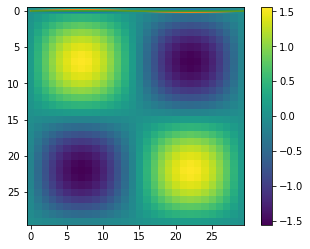

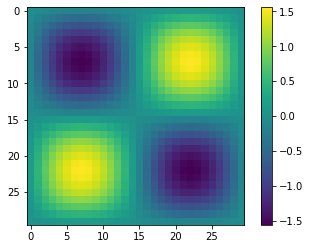

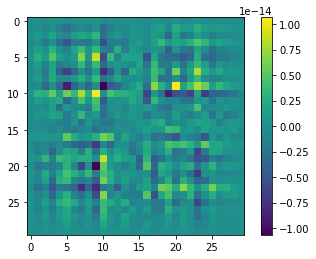

In [ ]:
# here write your solution

Dvx2=buildDxOperator(nxp,nyc,dx)
Dvx2=Dvx2.dot(vxSxL)

Dvy2=buildDyOperator(nxc,nyp,dy)
Dvy2=Dvy2.dot(vySyL)

plt.plot(Dvx2)
plt.plot(Dvy2)

plt.plot(Dvx2+Dvy2)

test2=Dvx2+Dvy2
print('should be zero:',test2[0])

print(np.shape(Dvx2))

print(np.shape(Dvx2))
Dvx2 = Dvx2.reshape(nxc,nyc)
Dvy2 = Dvy2.reshape(nxc,nyc)

p = plt.imshow(Dvx2)
plt.colorbar()
plt.show()
p = plt.imshow(Dvy2)
plt.colorbar()
plt.show()
p = plt.imshow(Dvx2+Dvy2)
plt.colorbar()
plt.show()

What is the goal of creating these operators? The reason is that these linear operators can be flexibly combined together in order to solve large problems and solve them as inverse problems, split the operations on many processors, insert material properties like variable viscosity or hydraulic conductivity, as I will show in the next chapters. 

For example we can invert our matrix-operator and find the velocity field, if enough data are available. Normally we don't know the strain rate, but we know the forcing, and therefore we can relate it to the stress and invert these equations to find the velocity field. To show another example, here I create two \emph{cell centered derivative operators} by combining the above created operators and use them to calculate the $xy$ strain rate of the above flow, and verify that it is correct:
 

In [ ]:


DxOp=buildDxOperator(nxp,nyc,dx)
DyOp=buildDyOperator(nxc,nyp,dy)

cellDxOp = np.dot(DxOp,sideXOp)    
cellDyOp = np.dot(DyOp,sideYOp)

vxSideX = 0.5*(Vx[:,0:nyp-1]+Vx[:,1:nyp])
vySideY = 0.5*(Vy[0:nxp-1,0:nyp]+Vy[1:nxp,0:nyp])
Dvx=( vxSideX[1:nxp,:] - vxSideX[0:nxp-1,:] )/dx
Dvy=( vySideY[:,1:nyp] - vySideY[:,0:nyp-1] )/dy

print ('error in SRxx: ', np.max(np.reshape(np.dot(cellDxOp,vxL), (nxc,nyc))-Dvx2), np.min(Dvx-Dvx2))

error in SRxx:  2.886579864025407e-15 -1.7763568394002505e-15


where the last line gives on my computer an error of the order of $10^{-15}$. This is the approach that we will look at in the next two Experiences. 

## Sparse Derivative Operator

Until now we did not spend much time looking at how efficient operators are. In fact, although they are a very elegant and efficient way to operate on our data, the ones that we have built are far from being computationally optimal. We can calculate the time required to perform a full calculation of xy strain rates using the above described operators:

In [ ]:
# Flow values 1d array
vxL=Vx.reshape(nxp*nyp)
vyL=Vy.reshape(nxp*nyp)

# Flow values turned into operator
vySxL = np.dot(sideXOp,vxL)
vxSyL = np.dot(sideYOp,vyL)

# dot product of dx Operator and flow vaue operators
DvyDxL = DxOp.dot(vxSxL)
DvxDyL = DyOp.dot(vxSyL)

SRxyL = 0.5*(DvyDxL+DvxDyL)
SRxy = SRxyL.reshape(nxc,nyc)


### Exercise 5

On my laptop these operations require about $72\;ms$ with $50 \times 100$ cells, although the direct calculation took half of a millisecond with  $200 \times 200$ cells. The reason of this huge difference is that we are creating giant operators of size $nx \times ny$. To reduce this time we have to start using sparse matrices. 
Test these timing for different sizes: $50 \times 50$, $100 \times 100$, $200 \times 200$, $400 \times 400$.

In [ ]:


nxp=101; nxc=nxp-1; nyp=101; nyc=nyp-1
xTot=1.0; dx=xTot/nxc; xMin=-xTot/2.0; xMax=xTot/2.0
yTot=1.0; dy=yTot/nyc; yMin=-yTot/2.0; yMax=yTot/2.0

# allocate the lattice arrays
X = np.arange(nxp, dtype=float)*dx+xMin  # x lattice coordinates
Y = np.arange(nyp, dtype=float)*dy+yMin  # y lattice coordinates

Vx = np.zeros((nxp,nyp), float)  # x-velocity at nodes
Vy = np.zeros((nxp,nyp), float)  # y-velocity at nodes

xNorm=(X+xMin)/xTot
yNorm=(Y+yMin)/yTot
for iy in np.arange(0,nyp):
    Vx[:,iy] = np.sin(np.pi*xNorm) * np.sin(np.pi*xNorm) * np.sin(np.pi*yNorm[iy]) * np.cos(np.pi*yNorm[iy])
for ix in np.arange(0,nxp):
    Vy[ix,:] =- np.sin(np.pi*yNorm) * np.sin(np.pi*yNorm) * np.sin(np.pi*xNorm[ix]) * np.cos(np.pi*xNorm[ix])

# Flow values 1d array
vxL=Vx.reshape(nxp*nyp)
vyL=Vy.reshape(nxp*nyp)

# Side operators for 1d arrays
sideXOp=buildSideOperatorX(nxp,nyp)
sideYOp=buildSideOperatorY(nxp,nyp)

# Flow values are averaged along x and Y
vxSxL = np.dot(sideXOp,vxL)
vySyL = np.dot(sideYOp,vyL)

# Define dx operator
DxOp=buildDxOperator(nxp,nyc,dx)
DyOp=buildDyOperator(nxc,nyp,dy)

# dot product of dx Operator and flow vaue operators
%timeit DvxDxL = DxOp.dot(vxSxL)
%timeit DvyDyL = DyOp.dot(vySyL)




10 loops, best of 5: 67.1 ms per loop
10 loops, best of 5: 68.4 ms per loop


Let's see how we can build the same two operators that allow us to do any derivative operation just using sparse operators. Of the many sparse arrays that exist in Python, the CSR format (Compressed Sparse Column format) is specially suitable for fast matrix vector products. Since all our matrix come from some combinations of diagonal matrices, we can combine them into a CSR format. Let's see how to do it. 

The strategy is simply to proceed in blocks. I show here how to make them with one technique based on diagonal sparse matrices, but other approaches (for example building directly a CSR sparse matrix) can be as efficient as this one, or even more, and the reader is welcome to test them and find better implementations. Following the approach described earlier, X axis operator will be based on large diagonals, while the Y axis operator on kron() of blocks that will be made of sparse diagonal matrices. Here there is a possible formulation:

In [ ]:
import scipy.sparse as sparse

def buildSparseOperatorXaxis(nx,ny,k1,k2):
    nx1=nx-1
    firstDiag=np.ones(nx*ny,float)*k1
    secondDiag=np.ones(nx*ny,float)*k2
    offsets=np.array([0,ny])
    return ( sparse.dia_matrix(([firstDiag,secondDiag],offsets), shape=(nx1*ny,nx*ny)).tocsr() )           

def buildSparseOperatorYaxis(nx,ny,k1,k2):
    ny1=ny-1
    firstDiag=np.ones(ny,float)*k1
    secondDiag=np.ones(ny,float)*k2
    offsets=np.array([0,1])
    block = sparse.dia_matrix(([firstDiag,secondDiag],offsets), shape=(ny1,ny)).tocsr()
    return (sparse.kron(sparse.eye(nx),block))     

*firstDiag* and *secondDiag* are longer than what they should be. The reason is that the command offset shifts the diagonal up, not to the right as we would like, so we have to create a longer *secondDiag* in order to cover the entire second diagonal. At the same time both diagonal arrays have to be long equal, therefore both are long and then cut when the matrix is created. 

Using these functions it is possible to calculate the operator for the xy Strain Rate in the following form:

    

In [ ]:
vxL=Vx.reshape(nxp*nyp)
vyL=Vy.reshape(nxp*nyp)
    
DxOp = buildSparseOperatorXaxis(nxp,nyc,-1.0/dx,1.0/dx)
DyOp = buildSparseOperatorYaxis(nxc,nyp,-1.0/dy,1.0/dy)
sideXOp =buildSparseOperatorYaxis(nxp,nyp, 0.5, 0.5)
sideYOp = buildSparseOperatorXaxis(nxp,nyp, 0.5, 0.5)
    
cellDxOp = DxOp.dot(sideXOp)    
cellDyOp = DyOp.dot(sideYOp)
    
SRxy = np.reshape(0.5*cellDyOp.dot(vxL)+0.5*cellDxOp.dot(vyL), (nxc,nyc))

### Exercise 6

Test these new algorithms for different sizes: $50 \times 50$, $100 \times 100$, $200 \times 200$, $400 \times 400$. and compare with the previous values.

In [ ]:
import numpy as np
import scipy.sparse as sparse

nxp=101; nxc=nxp-1; nyp=101; nyc=nyp-1
xTot=1.0; dx=xTot/nxc; xMin=-xTot/2.0; xMax=xTot/2.0
yTot=1.0; dy=yTot/nyc; yMin=-yTot/2.0; yMax=yTot/2.0

# allocate the lattice arrays
X = np.arange(nxp, dtype=float)*dx+xMin  # x lattice coordinates
Y = np.arange(nyp, dtype=float)*dy+yMin  # y lattice coordinates

Vx = np.zeros((nxp,nyp), float)  # x-velocity at nodes
Vy = np.zeros((nxp,nyp), float)  # y-velocity at nodes

xNorm=(X+xMin)/xTot
yNorm=(Y+yMin)/yTot
for iy in np.arange(0,nyp):
    Vx[:,iy] = np.sin(np.pi*xNorm) * np.sin(np.pi*xNorm) * np.sin(np.pi*yNorm[iy]) * np.cos(np.pi*yNorm[iy])
for ix in np.arange(0,nxp):
    Vy[ix,:] =- np.sin(np.pi*yNorm) * np.sin(np.pi*yNorm) * np.sin(np.pi*xNorm[ix]) * np.cos(np.pi*xNorm[ix])

# Flow values 1d array
vxL=Vx.reshape(nxp*nyp)
vyL=Vy.reshape(nxp*nyp)
print(np.shape(vxL))

# Side operators for 1d arrays
sideXOp=buildSideOperatorX(nxp,nyp)
sideYOp=buildSideOperatorY(nxp,nyp)
sideXOp=sparse.dia_matrix((sideXOp) ).tocsr()
sideYOp=sparse.dia_matrix((sideYOp) ).tocsr()
print(sideYOp)

# Flow values are averaged along x and Y
vxSxL = sideXOp.dot(vxL)
vySyL = sideYOp.dot(vyL)

# Define dx operator
DxOp=buildDxOperator(nxp,nyc,dx)
DxOp = sparse.dia_matrix((DxOp) ).tocsr()
DyOp=buildDyOperator(nxc,nyp,dy)
DyOp = sparse.dia_matrix((DyOp) ).tocsr()

%timeit DvxDxL = DxOp.dot(vxSxL)
%timeit DvyDyL = DyOp.dot(vySyL)









(10201,)


/usr/local/lib/python3.7/dist-packages/scipy/sparse/coo.py:434: SparseEfficiencyWarning: Constructing a DIA matrix with 102 diagonals is inefficient
  "is inefficient" % len(diags), SparseEfficiencyWarning)


  (0, 0)	0.5
  (0, 101)	0.5
  (1, 1)	0.5
  (1, 102)	0.5
  (2, 2)	0.5
  (2, 103)	0.5
  (3, 3)	0.5
  (3, 104)	0.5
  (4, 4)	0.5
  (4, 105)	0.5
  (5, 5)	0.5
  (5, 106)	0.5
  (6, 6)	0.5
  (6, 107)	0.5
  (7, 7)	0.5
  (7, 108)	0.5
  (8, 8)	0.5
  (8, 109)	0.5
  (9, 9)	0.5
  (9, 110)	0.5
  (10, 10)	0.5
  (10, 111)	0.5
  (11, 11)	0.5
  (11, 112)	0.5
  (12, 12)	0.5
  :	:
  (10087, 10188)	0.5
  (10088, 10088)	0.5
  (10088, 10189)	0.5
  (10089, 10089)	0.5
  (10089, 10190)	0.5
  (10090, 10090)	0.5
  (10090, 10191)	0.5
  (10091, 10091)	0.5
  (10091, 10192)	0.5
  (10092, 10092)	0.5
  (10092, 10193)	0.5
  (10093, 10093)	0.5
  (10093, 10194)	0.5
  (10094, 10094)	0.5
  (10094, 10195)	0.5
  (10095, 10095)	0.5
  (10095, 10196)	0.5
  (10096, 10096)	0.5
  (10096, 10197)	0.5
  (10097, 10097)	0.5
  (10097, 10198)	0.5
  (10098, 10098)	0.5
  (10098, 10199)	0.5
  (10099, 10099)	0.5
  (10099, 10200)	0.5


/usr/local/lib/python3.7/dist-packages/scipy/sparse/coo.py:434: SparseEfficiencyWarning: Constructing a DIA matrix with 101 diagonals is inefficient
  "is inefficient" % len(diags), SparseEfficiencyWarning)


10000 loops, best of 5: 33.2 µs per loop
10000 loops, best of 5: 33.4 µs per loop


Which on my laptop requires only 3 milliseconds for $100 \times 50$ cells, whereas the same approach using dense operators would require about 16 seconds, due to the extremely demanding matrix-matrix multiplication! We are now ready to head on towards solving physical problems for which we know physical properties and forces and we want to find the flow and calculate it accurately.
